# Jores et al 2021 Intepretation
**Authorship:**
Adam Klie, *08/12/2022*
***
**Description:**
Notebook to interpret the best trained models on the Jores et al dataset.
***

In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import glob
import logging
import torch
import numpy as np
import pandas as pd
import eugene as eu

Global seed set to 13
2022-08-14 20:30:57.359612: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-14 20:30:57.359676: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
eu.settings.dataset_dir = "../../_data/datasets/jores21"
eu.settings.output_dir = "../../_output/jores21"
eu.settings.logging_dir = "../../_logs/jores21"
eu.settings.config_dir = "../../_configs/jores21"
eu.settings.batch_size = 128
eu.settings.dl_num_workers = 4
eu.settings.verbosity = logging.ERROR

# Load in the `leaf`, `proto` and `combined` test `SeqData`s 

In [3]:
# Load in the preprocessed training data
sdata_leaf = eu.dl.read(os.path.join(eu.settings.output_dir, "leaf_test_sub_predictions.h5sd"))
#sdata_proto = eu.dl.read(os.path.join(eu.settings.output_dir, "proto_test_sub_predictions.h5sd"))
#sdata_combined = eu.dl.read(os.path.join(eu.settings.output_dir, "combined_test_sub_predictions.h5sd"))
sdata_leaf, #sdata_proto, sdata_combined

(SeqData object with = 100 seqs
 seqs = (100,)
 names = (100,)
 rev_seqs = (100,)
 ohe_seqs = (100, 170, 4)
 ohe_rev_seqs = (100, 170, 4)
 seqs_annot: 'GC', 'Jores21CNN_test_trial_1_enrichment_predictions', 'Jores21CNN_test_trial_2_enrichment_predictions', 'Jores21CNN_test_trial_3_enrichment_predictions', 'Jores21CNN_test_trial_4_enrichment_predictions', 'Jores21CNN_test_trial_5_enrichment_predictions', 'barcodes', 'batch', 'chromosome', 'end', 'enrichment', 'gene', 'mutations', 'set', 'sp', 'ssCNN_test_trial_1_enrichment_predictions', 'ssCNN_test_trial_2_enrichment_predictions', 'ssCNN_test_trial_3_enrichment_predictions', 'ssCNN_test_trial_4_enrichment_predictions', 'ssCNN_test_trial_5_enrichment_predictions', 'start', 'strand', 'type'
 pos_annot: None
 seqsm: None
 uns: None,)

In [4]:
# Load the best model

In [5]:
leaf_model_file = glob.glob(os.path.join(eu.settings.logging_dir, "Jores21CNN", f"test_leaf_trial_1", "checkpoints", "*"))[0]
leaf_model = eu.models.Jores21CNN.load_from_checkpoint(leaf_model_file)

In [6]:
saliency_methods = ["InputXGradient", "DeepLift", "GradientSHAP", "NaiveISM"]
for method in saliency_methods:
    eu.interpret.feature_attribution(
        leaf_model,
        sdata_leaf,
        saliency_method=method
    )

No transforms given, assuming just need to tensorize).


Computing saliency on batches: 0it [00:00, ?it/s]

No transforms given, assuming just need to tensorize).


Computing saliency on batches: 0it [00:00, ?it/s]

/home/vscode/.local/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:339: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


No transforms given, assuming just need to tensorize).


Computing saliency on batches: 0it [00:00, ?it/s]

Note: NaiveISM is not implemented yet for models other than single stranded ones
No transforms given, assuming just need to tensorize).


Computing saliency on batches: 0it [00:00, ?it/s]

Importance values: 0it [00:00, ?it/s]

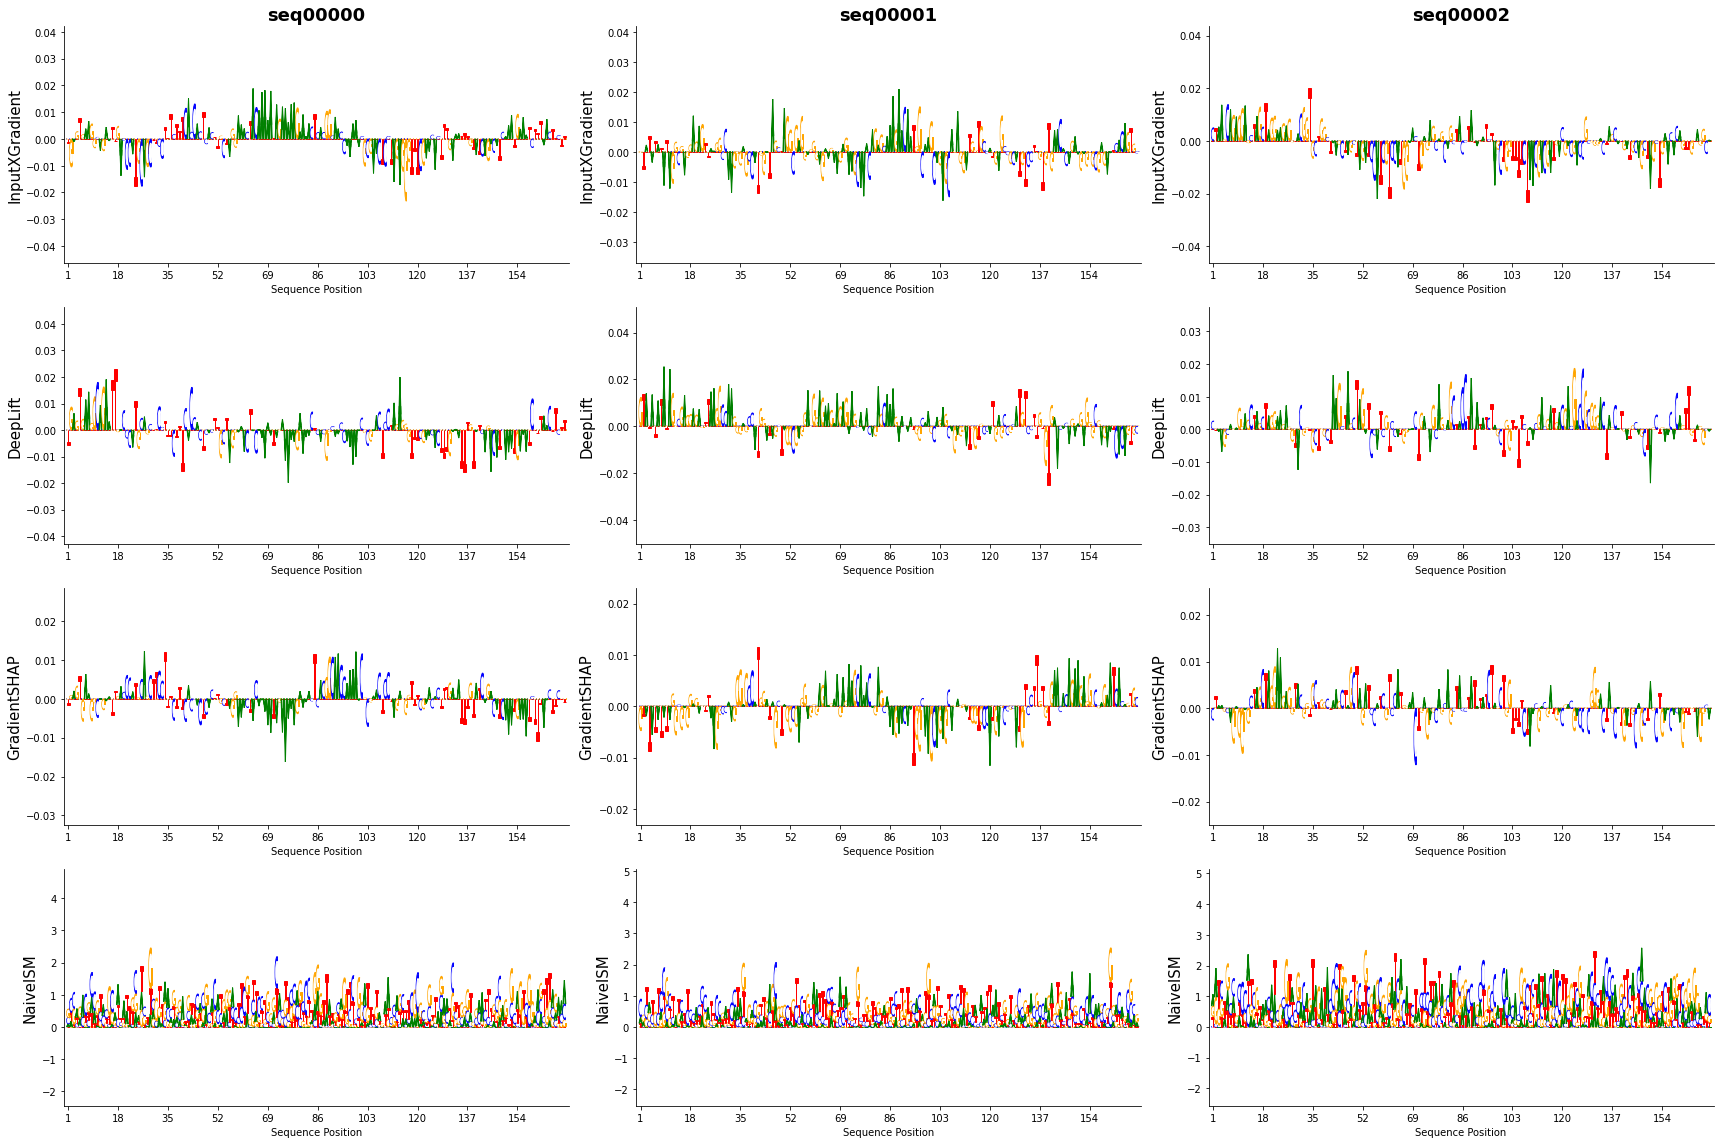

In [29]:
eu.pl.multiseq_track(
    sdata_leaf,
    seq_ids=sdata_leaf.names[:3],
    uns_keys = [method + "_imps" for method in saliency_methods],
    ylabels=saliency_methods
)

---

# Scratch

In [ ]:
import matplotlib.pyplot as plt
from eugene.plotting._seq import _plot_seq_logo
from tqdm.auto import tqdm
uns_keys = [method + "_imps" for method in ["InputXGradient", "DeepLift", "GradientSHAP", "NaiveISM"]]
ylabels = ["InputXGradient", "DeepLift", "GradientSHAP", "NaiveISM"]
seq_id = sdata.names[:2]
if isinstance(seq_id, str):
    seq_id = [seq_id]
if isinstance(uns_keys, str):
    uns_keys = [uns_keys]
seq_idx = np.where(sdata.seqs_annot.index.isin(seq_id))[0]
seqs = sdata.seqs[seq_idx]
print(seq_id, uns_keys, seq_idx, seqs)
fig_width = len(seq_id) * int(len(seqs[0]) / 20) # make each sequence width proportional to its length and multiply by the number of sequences
fig_height = len(uns_keys)*6
_, ax = plt.subplots(len(uns_keys), len(seq_id), figsize=(fig_width, fig_height))
for i, uns_key in tqdm(enumerate(uns_keys), desc=f"Importance values", position=0):
    for j, seq in tqdm(enumerate(seqs), desc=f"Plotting sequence", position=1):
        imp_scores = sdata.uns[uns_key][seq_idx[j]] if uns_key in sdata.uns.keys() else None
        _plot_seq_logo(
            ax.flatten()[i*len(seq_id)+j],
            seq,
            imp_scores=imp_scores,
            ylab=ylabels[i],
        )
        if i == 0:
            print(j*len(uns_keys))
            ax.flatten()[i*len(seq_id)+j].set_title(seq_id[j], fontsize=18, weight="bold")
plt.tight_layout()